In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from cg_dg_functions import *

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
# Exact solution
def initial_condition(x, case):
    
    '''
    This function compute the initial condition
    
    Inputs:
    -------
            x: variable
            case: 1 for Gaussain, 2 for sinusoidal function
            
    Output:
    -------
           return the initial condition according to the case
    '''
    
    if (case == 1):
        return exp(-128*x**2)
    elif(case == 2):
        return sin(2*pi*x)

    
#time stuff
def time_step(dx, ax, bx, CFL, nel0, N, u, time_final, fixed_dt):
    
    if (fixed_dt == True):
        dx0 = (bx-ax)/(nel0*N)
        dtest = CFL*dx0/abs(u)
        ntime0 = int(time_final//dtest) + 1   # Number of time steps
        dt0 = time_final/ntime0

        f = log2(dx0/dx)
        dt = dt0/2**f
        ntime = int(ntime0*2**f)
        print('ntime = {:d}'.format(ntime))
    else:        
        dtest = CFL*dx/abs(u)
        ntime = int(time_final/dtest) + 1    # Number of time steps
        dt = time_final/ntime
        print('ntime = {:d}'.format(ntime))
        
    return dt, ntime

In [5]:
poly_order = array([2,4])       # polynomial order
N_element = array([10,20])  # number of elements

kstages = 4               # RK2, RK3, RK4
dt = 1e-2                 # time-step, fraction of one revolution
CFL = 0.05                # CFL number
time_final = 0.025        # final time in revolutions
integration_type = 2      # %=1 is inexact and =2 is exact
method_type = 'dg'        # CG or DG
iplot = False             # plot the solution
icase = 2                 # case number: 1 is a Gaussian and 2 is a sinusoidal
diss = 0 
u = 2
ax = -1
bx = 1
ntime = time_final/dt;
l2_norm = zeros((len(poly_order), len(N_element)))
Np_array = zeros((len(poly_order), len(N_element)))

nel0 = N_element[0]

for iN in range(len(poly_order)):
    N = poly_order[iN]
    if (integration_type == 1):
        Q = N
    elif (integration_type == 2):
        Q = N+1
    for e in range(len(N_element)):
        nel = N_element[e]
        
        if (method_type == 'cg'):
            Np = nel*N + 1
        elif (method_type == 'dg'):
            Np = nel*(N+1)
        
        Np_array[iN,e] = Np
        
        #dx1 = (bx-ax)/(Np-1)
        #dt1, ntime1 = time_step(dx1, ax, bx, CFL, nel0, N, u, time_final, fixed_dt = False)
        # Call of 1D wave solver
        '''
        outputs:
        --------
        qexact         : Exact solution
        q              : Computed solution
        coord          : All grid points
        intma          : Intma(CG/DG)
        '''
        qexact, q, coord, intma = cg_dgSolver(N, Q, nel, Np, ax, bx, integration_type, method_type,\
                                icase,diss,u, CFL, time_final, kstages, initial_condition)
        
        
        # Compute L2- norm
        num = 0
        denom = 0
        #error = zeros((Np, Np))
        for i in range(Np):
            num = num + (q[i]-qexact[i])**2
            #error[i] = q[i]-qexact[i]
            denom = denom + (qexact[i])**2

        l2_norm[iN,e] = sqrt(num/denom)
        
        #Compute a gridpoint solution
        x_sol = zeros(Np);
        for ie in range(1,nel+1):
            for i in range(Q):
                ip = int(intma[i,ie-1])
                x_sol[ip] = coord[i,ie-1]
    
        if(iplot == True):
            figure(iN)
            plot(x_sol, qexact)
            plot(x_sol, q, '--')

<IPython.core.display.Javascript object>


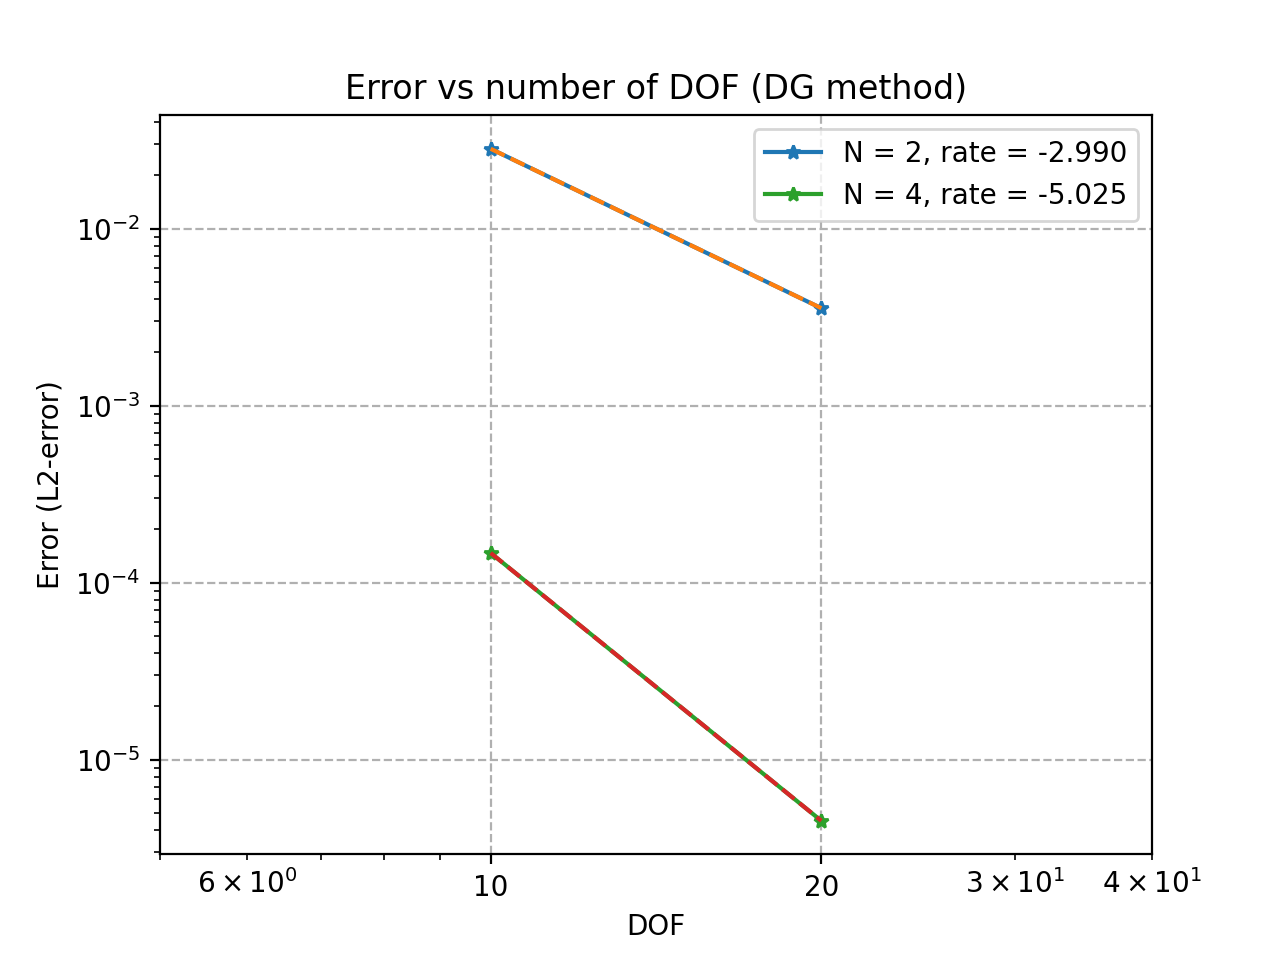

In [6]:
import cg_graphics
figure(2)
clf()
P = []   

for i in range(len(poly_order)):
    N = poly_order[i]
    #Nv = Np_array[i]
    Nv = N_element
    if(N == 6):
        p = polyfit(log(Nv[:3]), log(l2_norm[i][:3]), 1)
    else:
        p = polyfit(log(Nv), log(l2_norm[i]), 1)
        
    P.append(p[0])
    loglog(Nv, l2_norm[i], '-*',markersize=5, label = 'N = {:d}, rate = {:.3f}'.format(N,p[0]))
    
    loglog(Nv, exp(polyval(p,log(Nv))), '--')
    
cg_graphics.set_xticks(N_element)
xlabel('DOF')
ylabel('Error (L2-error)')
title('Error vs number of DOF ({:s} method)'.format(method_type.upper()))
#cg_graphics.set_xticks(N_element*N)  # Create nice tick marks for NE
grid(axis='both',linestyle='--')
legend()
show()   